<a href="https://colab.research.google.com/github/rafio-iut/Vegetable-Classification-and-Quality-Assessment/blob/main/Vegetable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

import torch
import torch.nn as nn
from torch.utils.data import Subset
from torch.utils.data import ConcatDataset
import torch.optim as optim
import torchvision
from torchvision import models, transforms

import math
import time
import random
import os
import copy

# Initialize Environment

## Setup GPU

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Clone Repository and Setup Environment

In [12]:
!rm -r *

!git clone https://github.com/rafio-iut/Vegetable-Classification-and-Quality-Assessment.git

!mv Vegetable-Classification-and-Quality-Assessment/* .

!rm -r Vegetable-Classification-and-Quality-Assessment

Cloning into 'Vegetable-Classification-and-Quality-Assessment'...
remote: Enumerating objects: 6196, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 6196 (delta 9), reused 17 (delta 6), pack-reused 6176
Receiving objects: 100% (6196/6196), 120.86 MiB | 29.21 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (6153/6153), done.


# Preprocess Data

## Explode Directories

In [13]:
root_dir = '/content/New VegNet'

for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)

    if os.path.isdir(folder_path):
        for subfolder_name in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder_name)

            if os.path.isdir(subfolder_path):
                new_folder_name = folder_name + ' - ' + subfolder_name
                new_folder_name = new_folder_name.split('. ')[1]
                new_folder_path = os.path.join(root_dir, new_folder_name)

                os.makedirs(new_folder_path, exist_ok=True)

                for file_name in os.listdir(subfolder_path):
                    file_path = os.path.join(subfolder_path, file_name)
                    new_file_path = os.path.join(new_folder_path, file_name)
                    shutil.move(file_path, new_file_path)

                os.rmdir(subfolder_path)

## Delete Empty Folders

In [14]:
root_dir = '/content/New VegNet'
for root, dirs, files in os.walk(root_dir, topdown=False):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            if not os.listdir(folder_path):
                os.rmdir(folder_path)

## Load Dataset

In [15]:
root_dir = '/content/New VegNet'

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = torchvision.datasets.ImageFolder(root=root_dir, transform=transform)
classes = dataset.classes

## Display Dataset

In [16]:
def get_class_counts(dataset):
    targets = [target for _, target in dataset]

    class_counts = {}
    for target in targets:
        label = classes[target]
        if label in class_counts: class_counts[label] += 1
        else: class_counts[label] = 1

    return class_counts

def get_class_images(dataset):
    class_images = {}
    for image, target in dataset:
        label = classes[target]
        if label not in class_images: class_images[label] = image

    return class_images

def display_dataset(dataset, dataset_name):
    class_counts = get_class_counts(dataset)
    df_class_counts = pd.concat([pd.DataFrame({'Class Label': list(class_counts.keys())}),
                                 pd.DataFrame({'Sample Count': list(class_counts.values())})], axis=1)

    total_samples = df_class_counts['Sample Count'].sum()
    df_class_counts.loc[len(df_class_counts)] = ['Total Samples', total_samples]

    print(dataset_name)
    display(df_class_counts)
    print()

In [17]:
display_dataset(dataset, 'Total Dataset')

Total Dataset


,Class Label,Sample Count
0,Bell Pepper - Damaged,31
1,Bell Pepper - Dried,296
2,Bell Pepper - Old,349
3,Bell Pepper - Ripe,448
4,Bell Pepper - Unripe,52
5,Chile Pepper - Damaged,121
6,Chile Pepper - Dried,593
7,Chile Pepper - Old,200
8,Chile Pepper - Ripe,183
9,Chile Pepper - Unripe,189


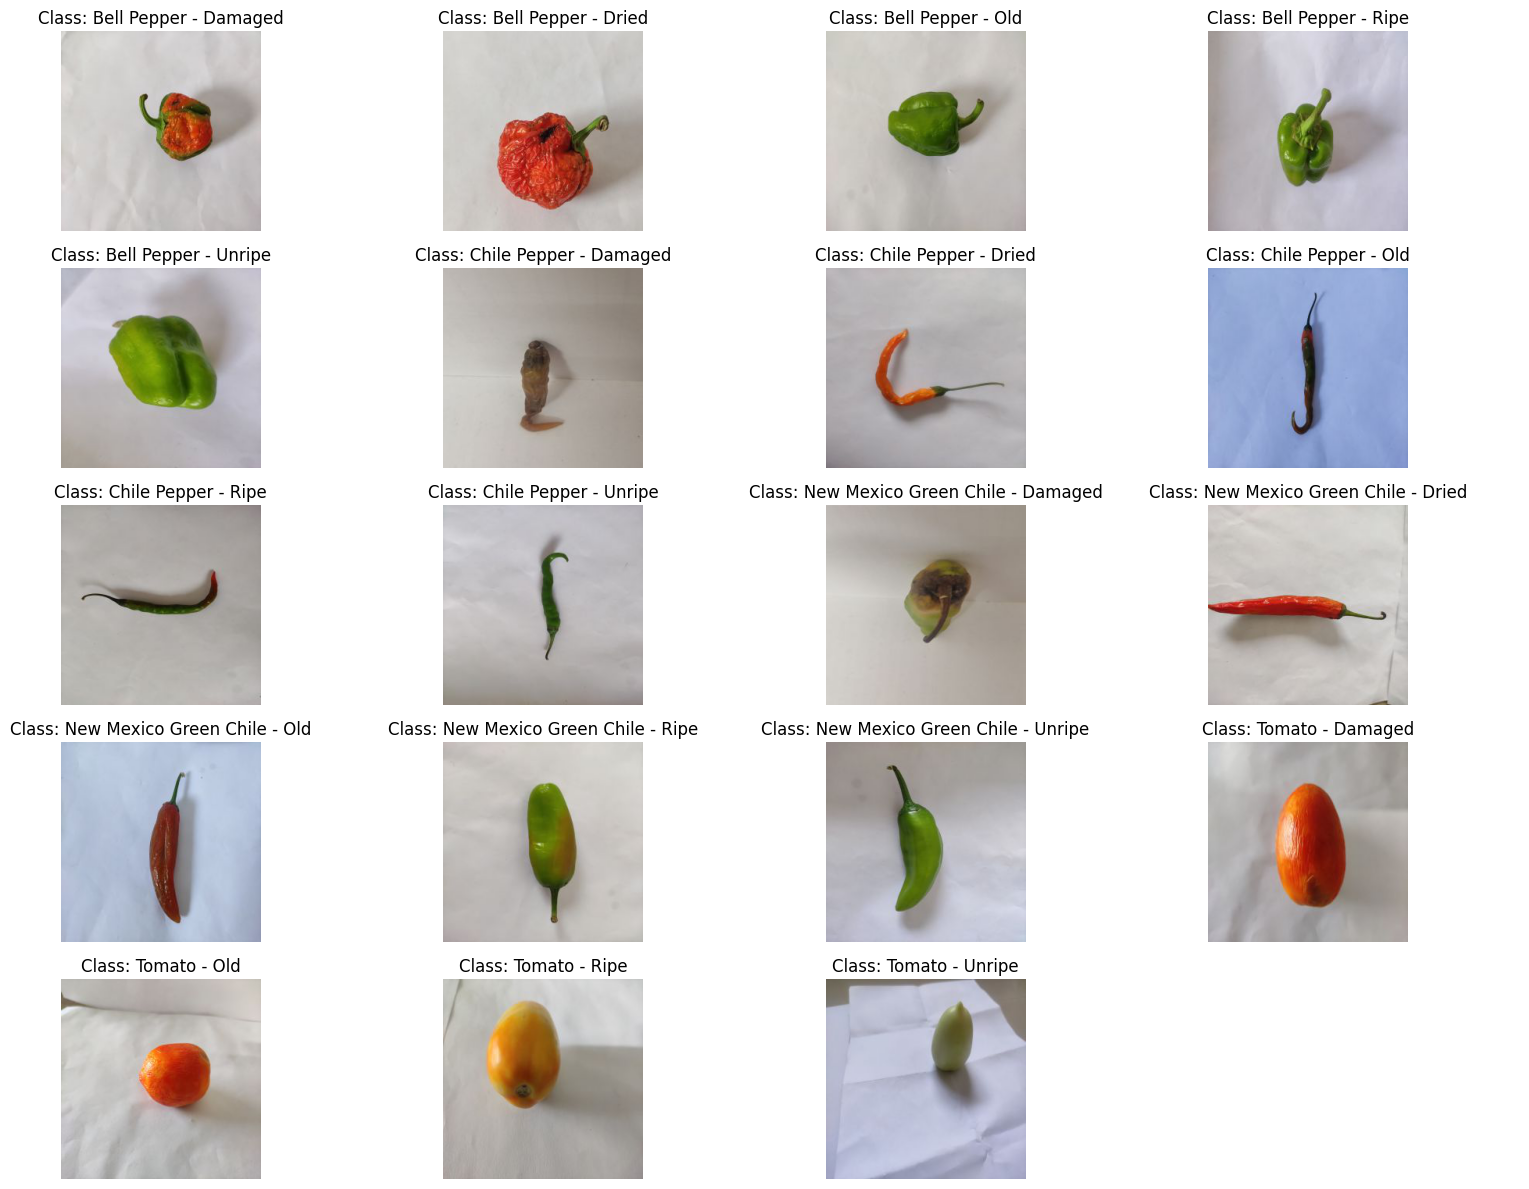

In [18]:
class_images = get_class_images(dataset)

num_classes = len(class_images)
num_cols = 4
num_rows = math.ceil(num_classes / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))

for i, (label, image) in enumerate(class_images.items()):
    row = i // num_cols
    col = i % num_cols

    image = image.numpy().transpose(1, 2, 0)

    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.imshow(image)
    ax.set_title(f'Class: {label}')
    ax.axis('off')

for i in range(len(class_images), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols

    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.axis('off')

plt.tight_layout()
plt.show()

## K-Fold Cross Validation

In [19]:
targets = [target for _, target in dataset]

k = 5
c = len(classes)

class_subsets = [[] for _ in range(c)]
for idx, target in enumerate(targets): class_subsets[target].append(idx)

subset_indices = [[] for _ in range(k)]

for class_subset in class_subsets:
    random.shuffle(class_subset)
    subset_size = len(class_subset) // k
    leftover_samples = len(class_subset) % k

    for i in range(k):
        start_idx = i * subset_size
        end_idx = (i + 1) * subset_size
        subset_indices[i].extend(class_subset[start_idx:end_idx])

    random.shuffle(class_subset)
    for i in range(leftover_samples):
        subset_indices[i].append(class_subset[i])
    random.shuffle(class_subset)

datasubset = []
for indices in subset_indices:
    subset = Subset(dataset, indices)
    datasubset.append(subset)

for i, subset in enumerate(datasubset): display_dataset(subset, f'Subset {i+1}')

Subset 1


,Class Label,Sample Count
0,Bell Pepper - Damaged,7
1,Bell Pepper - Dried,60
2,Bell Pepper - Old,70
3,Bell Pepper - Ripe,90
4,Bell Pepper - Unripe,11
5,Chile Pepper - Damaged,25
6,Chile Pepper - Dried,119
7,Chile Pepper - Old,40
8,Chile Pepper - Ripe,37
9,Chile Pepper - Unripe,38



Subset 2


,Class Label,Sample Count
0,Bell Pepper - Damaged,6
1,Bell Pepper - Dried,59
2,Bell Pepper - Old,70
3,Bell Pepper - Ripe,90
4,Bell Pepper - Unripe,11
5,Chile Pepper - Damaged,24
6,Chile Pepper - Dried,119
7,Chile Pepper - Old,40
8,Chile Pepper - Ripe,37
9,Chile Pepper - Unripe,38



Subset 3


,Class Label,Sample Count
0,Bell Pepper - Damaged,6
1,Bell Pepper - Dried,59
2,Bell Pepper - Old,70
3,Bell Pepper - Ripe,90
4,Bell Pepper - Unripe,10
5,Chile Pepper - Damaged,24
6,Chile Pepper - Dried,119
7,Chile Pepper - Old,40
8,Chile Pepper - Ripe,37
9,Chile Pepper - Unripe,38



Subset 4


,Class Label,Sample Count
0,Bell Pepper - Damaged,6
1,Bell Pepper - Dried,59
2,Bell Pepper - Old,70
3,Bell Pepper - Ripe,89
4,Bell Pepper - Unripe,10
5,Chile Pepper - Damaged,24
6,Chile Pepper - Dried,118
7,Chile Pepper - Old,40
8,Chile Pepper - Ripe,36
9,Chile Pepper - Unripe,38



Subset 5


,Class Label,Sample Count
0,Bell Pepper - Damaged,6
1,Bell Pepper - Dried,59
2,Bell Pepper - Old,69
3,Bell Pepper - Ripe,89
4,Bell Pepper - Unripe,10
5,Chile Pepper - Damaged,24
6,Chile Pepper - Dried,118
7,Chile Pepper - Old,40
8,Chile Pepper - Ripe,36
9,Chile Pepper - Unripe,37


In [20]:
def get_data_splits(datasubset, test_index):
    data_split = {}

    testset = datasubset[test_index]
    trainvalset = ConcatDataset(datasubset[:test_index] + datasubset[test_index+1:])

    targets = [target for _, target in trainvalset]
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=7)
    train_indices, val_indices = next(stratified_split.split(targets, targets))

    trainset = Subset(trainvalset, train_indices)
    valset = Subset(trainvalset, val_indices)

    data_split['train'] = trainset
    data_split['val'] = valset
    data_split['test'] = testset

    return data_split

## Prepare Data Loaders

In [21]:
k = 5
data_splits = []
dataloaders = []

for i in range(k):
    split = get_data_splits(datasubset, i)
    loader = {x: torch.utils.data.DataLoader(split[x], batch_size=4, shuffle=True, num_workers=2)
                      for x in ['train', 'val', 'test']}
    data_splits.append(split)
    dataloaders.append(loader)

# Training Functions

In [ ]:
def run_step(data_split, dataloader, model, preprocess, criterion, optimizer, scheduler, phase):
    running_loss = 0.0
    running_corrects = 0

    for images, targets in dataloader[phase]:
        images = [preprocess(image) for image in images]
        images = torch.stack(images)
        images = images.to(device)
        targets = targets.to(device)

        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, targets)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == targets.data)

    if phase == 'train': scheduler.step()

    step_loss = running_loss / len(data_split[phase])
    step_acc = running_corrects.double() / len(data_split[phase])

    return step_loss, step_acc

def train_model(data_split, dataloader, model, preprocess, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1, 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train': model.train()
            else: model.eval()

            step_loss, step_acc = run_step(data_split, dataloader, model, preprocess, criterion, optimizer, scheduler, phase)
            print('{} Loss: {:.4f}, Acc: {:.2f}%'.format(phase, step_loss, step_acc*100))

            if phase == 'val' and step_acc > best_acc:
                best_acc = step_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.2f}%'.format(best_acc*100))

    _, test_acc = run_step(data_split, dataloader, model, preprocess, criterion, optimizer, scheduler, 'test')
    print('Test Acc: {:.2f}%'.format(test_acc*100))

    model.load_state_dict(best_model_wts)
    return model, test_acc

def run_model(model, preprocess, model_name, results_df, k=5):
    base_state = copy.deepcopy(model.state_dict())
    result = {'Model': model_name}

    for testset_index in range(k):
        model.load_state_dict(base_state)
        print(f'Test Set {testset_index+1}:')
        print('-' * 20)
        print()

        data_split = data_splits[testset_index]
        dataloader = dataloaders[testset_index]

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        _, acc = train_model(data_split, dataloader, model, preprocess, criterion, optimizer, scheduler)
        acc = acc.cpu().item()

        result[f'Testset-{testset_index + 1} Accuracy'] = acc
        print()

    results_df = pd.concat([results_df, pd.DataFrame(result, index=[0])], ignore_index=True)
    return results_df

# Setup DataFrame

In [ ]:
def to_percentage(x):
    return f'{x*100:.2f}%'

def from_percentage(percentage):
    percentage = percentage.rstrip('%')
    try:
        decimal = float(percentage) / 100
        return decimal
    except ValueError:
        raise ValueError("Invalid Format")

k = 5
results_df = pd.DataFrame(columns=['Model'] + [f'Testset-{i+1} Accuracy' for i in range(k)] + ['Average Accuracy'])

# Run Models

## ResNet-50

In [ ]:
model_name = 'ResNet-50'
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights)
preprocess = weights.transforms(antialias=None)

model.fc = nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)

In [ ]:
results_df = run_model(model, preprocess, model_name, results_df)

Test Set 1:
--------------------

Epoch 1/5
----------
train Loss: 1.1943, Acc: 61.83%
val Loss: 0.4194, Acc: 85.99%
Epoch 2/5
----------
train Loss: 0.4285, Acc: 85.88%
val Loss: 0.2300, Acc: 91.78%
Epoch 3/5
----------
train Loss: 0.2383, Acc: 92.45%
val Loss: 0.2203, Acc: 92.75%
Epoch 4/5
----------
train Loss: 0.1513, Acc: 95.36%
val Loss: 0.1029, Acc: 97.07%
Epoch 5/5
----------
train Loss: 0.0958, Acc: 96.99%
val Loss: 0.1599, Acc: 94.54%

Training complete in 5m 53s
Best val Acc: 97.07%
Test Acc: 95.32%

Test Set 2:
--------------------

Epoch 1/5
----------
train Loss: 1.2155, Acc: 61.81%
val Loss: 0.4668, Acc: 83.90%
Epoch 2/5
----------
train Loss: 0.4384, Acc: 85.54%
val Loss: 0.2367, Acc: 91.46%
Epoch 3/5
----------
train Loss: 0.2598, Acc: 91.56%
val Loss: 0.2091, Acc: 92.28%
Epoch 4/5
----------
train Loss: 0.1699, Acc: 94.49%
val Loss: 0.1779, Acc: 94.80%
Epoch 5/5
----------
train Loss: 0.1256, Acc: 96.15%
val Loss: 0.2167, Acc: 91.95%

Training complete in 5m 46s
Best 

## AlexNet

In [ ]:
model_name = 'AlexNet'
weights = models.AlexNet_Weights.IMAGENET1K_V1
model = models.alexnet(weights=weights)
preprocess = weights.transforms(antialias=None)

model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(classes))
model = model.to(device)

In [ ]:
results_df = run_model(model, preprocess, model_name, results_df)

Test Set 1:
--------------------

Epoch 1/5
----------
train Loss: 2.1922, Acc: 33.36%
val Loss: 1.4830, Acc: 49.67%
Epoch 2/5
----------
train Loss: 1.2991, Acc: 58.82%
val Loss: 0.9746, Acc: 66.61%
Epoch 3/5
----------
train Loss: 0.9631, Acc: 67.73%
val Loss: 0.7757, Acc: 73.70%
Epoch 4/5
----------
train Loss: 0.7464, Acc: 75.33%
val Loss: 0.6313, Acc: 79.80%
Epoch 5/5
----------
train Loss: 0.5929, Acc: 80.40%
val Loss: 0.4617, Acc: 84.04%

Training complete in 3m 12s
Best val Acc: 84.04%
Test Acc: 84.73%

Test Set 2:
--------------------

Epoch 1/5
----------
train Loss: 2.1845, Acc: 32.71%
val Loss: 1.5563, Acc: 48.29%
Epoch 2/5
----------
train Loss: 1.2655, Acc: 59.18%
val Loss: 0.7649, Acc: 72.93%
Epoch 3/5
----------
train Loss: 0.8762, Acc: 71.11%
val Loss: 0.5678, Acc: 81.79%
Epoch 4/5
----------
train Loss: 0.6927, Acc: 78.00%
val Loss: 0.7567, Acc: 74.88%
Epoch 5/5
----------
train Loss: 0.6327, Acc: 79.60%
val Loss: 0.7337, Acc: 77.07%

Training complete in 3m 12s
Best 

## DenseNet-169

In [ ]:
model_name = 'DenseNet-169'
weights = models.DenseNet169_Weights.IMAGENET1K_V1
model = models.densenet169(weights=weights)
preprocess = weights.transforms(antialias=None)

model.classifier = nn.Linear(model.classifier.in_features, len(classes))
model = model.to(device)

In [ ]:
results_df = run_model(model, preprocess, model_name, results_df)

Test Set 1:
--------------------

Epoch 1/5
----------
train Loss: 0.9239, Acc: 70.71%
val Loss: 0.2618, Acc: 90.96%
Epoch 2/5
----------
train Loss: 0.4047, Acc: 86.83%
val Loss: 0.1929, Acc: 94.79%
Epoch 3/5
----------
train Loss: 0.2305, Acc: 92.94%
val Loss: 0.1413, Acc: 95.03%
Epoch 4/5
----------
train Loss: 0.1709, Acc: 94.54%
val Loss: 0.1336, Acc: 95.93%
Epoch 5/5
----------
train Loss: 0.1217, Acc: 96.09%
val Loss: 0.1151, Acc: 96.74%

Training complete in 9m 41s
Best val Acc: 96.74%
Test Acc: 96.77%

Test Set 2:
--------------------

Epoch 1/5
----------
train Loss: 0.9363, Acc: 70.36%
val Loss: 0.1837, Acc: 94.23%
Epoch 2/5
----------
train Loss: 0.4014, Acc: 87.42%
val Loss: 0.2379, Acc: 92.20%
Epoch 3/5
----------
train Loss: 0.2593, Acc: 91.70%
val Loss: 0.1413, Acc: 95.28%
Epoch 4/5
----------
train Loss: 0.1920, Acc: 94.41%
val Loss: 0.1088, Acc: 96.18%
Epoch 5/5
----------
train Loss: 0.1516, Acc: 95.25%
val Loss: 0.0971, Acc: 96.99%

Training complete in 9m 38s
Best 

# View Results

## Calculate Average Accuracy

In [ ]:
results_df['Average Accuracy'] = results_df.iloc[:, 1:].mean(axis=1)

## Display Results

In [ ]:
results_df['Average Accuracy'] = results_df['Average Accuracy'].map(to_percentage)

for i in range(k):
    results_df[f'Testset-{i+1} Accuracy'] = results_df[f'Testset-{i+1} Accuracy'].map(to_percentage)

display(results_df)

results_df['Average Accuracy'] = results_df['Average Accuracy'].map(from_percentage)

for i in range(k):
    results_df[f'Testset-{i+1} Accuracy'] = results_df[f'Testset-{i+1} Accuracy'].map(from_percentage)

,Model,Testset-1 Accuracy,Testset-2 Accuracy,Testset-3 Accuracy,Testset-4 Accuracy,Testset-5 Accuracy,Average Accuracy
0,ResNet-50,95.32%,94.16%,95.28%,96.66%,97.22%,95.73%
1,AlexNet,84.73%,77.37%,20.08%,75.69%,80.95%,67.76%
2,DenseNet-169,96.77%,98.13%,96.99%,98.78%,97.06%,97.55%
